In [1]:
import numpy as np
import pylab as plt

# 2. Линейные модели и Градиентный спуск.

Альтернативное изложение некоторых частей материала есть [тут](https://alexanderdyakonov.wordpress.com/2019/10/31/%D0%BB%D0%B8%D0%BD%D0%B5%D0%B9%D0%BD%D0%B0%D1%8F-%D1%80%D0%B5%D0%B3%D1%80%D0%B5%D1%81%D1%81%D0%B8%D1%8F/), весьма рекомендуется к ознакомлению. 

Если хочется увидеть взгляд на то же самое со стороны Байесианского подхода, рекомендую прочесть главу `2.2 Функции ошибки и регуляризация` в книге С. Николенко "Глубокое обучение погружение в мир нейронных сетей", её несложно *найти*. 

# Пререквизиты про производную

Копипаста с [википедии](https://ru.wikipedia.org/wiki/%D0%9F%D1%80%D0%BE%D0%B8%D0%B7%D0%B2%D0%BE%D0%B4%D0%BD%D0%B0%D1%8F_%D1%84%D1%83%D0%BD%D0%BA%D1%86%D0%B8%D0%B8#%D0%9E%D0%BF%D1%80%D0%B5%D0%B4%D0%B5%D0%BB%D0%B5%D0%BD%D0%B8%D0%B5)

Производная функции $y(x):\mathbb{R} \rightarrow \mathbb{R}$ в точке $x_0$ по определению - это 
$$y^{\prime}\left(x_0\right)=\lim _{x \rightarrow x_0} \frac{y(x)-y\left(x_0\right)}{x-x_0}=\lim _{\Delta x \rightarrow 0} \frac{y\left(x_0+\Delta x\right)-y\left(x_0\right)}{\Delta x}=\lim _{\Delta x \rightarrow 0} \frac{\Delta y(x)}{\Delta x}$$

По смыслу - это скорость роста функции в точке. Чем больше функция похожа на линейную, тем лучше описывает её поведение на некотором отдалении от точки $x_0$ производная первого порядка.

<img src="images/derivative.png" alt="drawing" width="800" style="background-color:white;"/>

# Начнём


В данном ноутбуке векторы - всегда **столбцы**! 

Если нужно показать, что векторы - **строки**, он обозначается знаком транспонирования: $\boldsymbol{x}^T$

Однако, вектор объекта в матрице $X$ лежит **горизонтально**! (Признаки по столбцам, объекты по строкам)

Множества ответов $Y$ будем обозначать как $\boldsymbol{y}$, потому что такая нотация используется почти везде

Пререквизиты:
* $n$ - количество объектов в выборке
* $m$ - количество признаков у объекта
* $t$ - итерация по шагам градиентного спуска (ставится сверху)
* $x$ - число, элемент вектора
* $\boldsymbol{x}$ - вектор
* $X$ - матрица
* $E_{a\times b}$ - матрица с диагональю из единиц и нулями на прочих местах
* $O_{a\times b}$ - нулевая матрица
* $I_{a\times b}$ - матрица из всех единиц

Можно ли, чтобы функция (в математическом смысле) $F(x)$ - возвращала не число, а вектор? Например $F(\boldsymbol{x}) = c\boldsymbol{x}$, где $\boldsymbol{x}$ - вектор, $c$ - константа. Можно ли считать производные у таких функций?

Да, можно брать любые тензоры и брать производные любых размеров. 

Пусть $F(\boldsymbol{x}) = (f_1(\boldsymbol{x}), \ldots, f_m(\boldsymbol{x})): \mathbb{R}^{n} \to \mathbb{R^m}$. Тогда производной по $x$ можно назвать вот такое:

$$\nabla_{\boldsymbol{x}}F =
\frac{dF}{d\boldsymbol{x}} =  
\begin{pmatrix}
\frac{\partial f_1(x)}{\partial x_{1}} & \ldots & \frac{\partial f_m(x)}{\partial x_{1}}  \\
\frac{\partial f_1(x)}{\partial x_{2}}  & \ldots & \frac{\partial f_m(x)}{\partial x_{2}} \\
\vdots  \\
\frac{\partial f_1(x)}{\partial x_{n}}  & \ldots & \frac{\partial f_m(x)}{\partial x_{n}}
\end{pmatrix}
$$ 

Сегодня мы будем пользоваться функциями только с образами в $\mathbb{R}^n$, притом мы ограничимся очень небольшим их набором. Тем, кому интересно почитать про матричные производные более подробно - [вот сюда](https://en.wikipedia.org/wiki/Matrix_calculus), а если *очень* интересно, то [сюда](https://project.hupili.net/tutorial/hu2012-matrix-calculus/hu2012matrix-calculus.pdf) и [сюда](https://arxiv.org/pdf/1802.01528.pdf)

# Пример 0

Дано $y (x) = x^T a; \quad \quad a,x \in \mathbb{R}^n$

Найти $\frac{dy}{d\boldsymbol{x}}$

$$
\frac{dy}{d\boldsymbol{x}} = \frac{d(\sum_{i=1}^{n}a_i x_i)}{d\boldsymbol{x}} = 
\begin{pmatrix}
\frac{\partial \sum_{i=1}^{n}a_i x_i}{\partial x_1} \\
\frac{\partial \sum_{i=1}^{n}a_i x_i}{\partial x_2} \\
\vdots  \\
\frac{\partial \sum_{i=1}^{n}a_i x_i}{\partial x_n}
\end{pmatrix}
=
\begin{pmatrix}
a_1 \\
a_2 \\
\vdots  \\
a_n
\end{pmatrix}
=
\boldsymbol{a}
$$


## Пример 1

Дано $y = \boldsymbol{x}^T\boldsymbol{x},  \quad \boldsymbol{x} \in \mathbb{R}^n$

Найти $\frac{dy}{d\boldsymbol{x}}$

$$
\frac{dy}{d\boldsymbol{x}} = \frac{d(\sum_{i=1}^{n}x_i^2)}{d\boldsymbol{x}} = 
\begin{pmatrix}
\frac{\partial \sum_{i=1}^{n}x_i^2}{\partial x_1} \\
\frac{\partial \sum_{i=1}^{n}x_i^2}{\partial x_2} \\
\vdots  \\
\frac{\partial \sum_{i=1}^{n}x_i^2}{\partial x_n}
\end{pmatrix}
=
\begin{pmatrix}
2x_1 \\
2x_2 \\
\vdots  \\
2x_n
\end{pmatrix}
=
2\boldsymbol{x}
$$ 

## Пример 2

Дано $ y (A) = tr(AB) \quad A,B \in \mathbb{R}^{N \times N} $

Найти $\frac{dy}{dA}$ 

$$
\frac{dy}{dA} = \frac{d(\sum_{i=1}^{N}(AB)_{i,i})}{dA} = \frac{d(\sum_{i=1}^{N} \sum_{r=1}^{N}a_{i,r}b_{r,i})}{dA} =
\begin{pmatrix}
\frac{\partial \sum_{i=1}^{N}\sum_{r=1}^{N}a_{i,r}b_{r,i}}{\partial a_{1,1}} & \ldots & 
\frac{\partial \sum_{i=1}^{N}\sum_{r=1}^{N}a_{i,r}b_{r,i}}{\partial a_{1,N}} \\
\frac{\partial \sum_{i=1}^{N}\sum_{r=1}^{N}a_{i,r}b_{r,i}}{\partial a_{2,1}} & \ldots & 
\frac{\partial \sum_{i=1}^{N}\sum_{r=1}^{N}a_{i,r}b_{r,i}}{\partial a_{2,N}}\\
\vdots & \ldots & \vdots \\
\frac{\partial \sum_{i=1}^{N}\sum_{r=1}^{N}a_{i,r}b_{r,i}}{\partial a_{N,1}} & \ldots & 
\frac{\partial \sum_{i=1}^{N}\sum_{r=1}^{N}a_{i,r}b_{r,i}}{\partial a_{N,N}} 
\end{pmatrix} =
\begin{pmatrix}
b_{1,1} & \ldots & b_{N,1} \\
b_{1,2} & \ldots & b_{N,2} \\
\vdots  & \ldots & \vdots \\
b_{1,N} & \ldots & b_{N,N}
\end{pmatrix} = B^{T}
$$

# Важный вопрос:

<img src="images/meme.jpeg" alt="drawing" width="400" style="background-color:white;"/>


Зачем ещё одна пугающая нотация? Ну почему бы не воспринимать это просто как функцию от $N * N$ аргументов, каждый из которых обычное число из $\mathbb{R}$?


В основном потому, что расчёты становятся монструозно сложными, смотрите.

Пусть $C = AB$

$ y (A) = tr(AB) = tr(C) = \sum_{i=1}^N C_{i,i} = \sum_{i=1}^N (A_i, B_i) = \sum_{i=1}^N \sum_{j = 1}^N A_{i,j}*B_{j,i} $

Неприятно с таким в лоб воевать, конкретный вычисленный результат ещё и от размерности матриц зависит в такой нотации. Неприятно, сложно, не хочется. А нотация матричного дифференцирования позволяет выстроить удобный "фреймворк", вроде таблиц дифференцирования, когда вы просто знаете, что 

для   $x \in \mathbb{R},\quad\quad(x^2)' = 2x$, 

а для $x \in \mathbb{R}^n,\quad(x^T x)' = 2x$

# 3.2 Линейная регрессия
## Постановка задачи

Давайте вспомним, что такое задача линейной регрессии в рамках машинного обучения. 

У нас есть обучающая выборка $(X, \boldsymbol{y})$, c $n$ объектами и $m$ признаками. (Значит размер $X$ - $n\times m$)

Алгоритм решения выбирается из пространства линейных функций:

$a(\boldsymbol{x}_k) = w_0 + w_1x_{k, 1} + \ldots + w_mx_{k, m}$


## Точное решение 

Нам нужно найти такое $a(\cdot)$, чтобы решилась система уравнений
$$\begin{cases}
a(\boldsymbol{x}_1) = w_0 + w_1x_{1,1} + \ldots + w_mx_{1,m} =  y_1\\
\ldots \\
a(\boldsymbol{x}_k) = w_0 + w_1x_{k,1} + \ldots + w_mx_{k,m} =  y_k\\
\ldots \\
a(\boldsymbol{x}_n) = w_0 + w_1x_{n,1} + \ldots + w_mx_{n,m} =  y_n
\end{cases}$$

Давайте запишем в матричном виде, предварительно добавив к $X$ единичный столбец слева. $X = (I_{n\times 1}|X)$. Получим:

$$X\boldsymbol{w} = \boldsymbol{y}$$

С курса линейной алгебры мы помним, что система линейных уравнений имеет единственное решение, когда $X$ - квадратная, максимального ранга (нет линейно зависимых строк\столбцов). По сути, если у $X$ существует обратная, тогда:

$$\boldsymbol{w} = X^{-1}\boldsymbol{y}$$

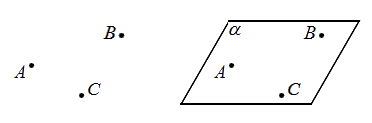

In [2]:
from IPython.display import Image
Image('images/плоскость.png')

Однако никто нам не гарантирует, что матрица $X$ будет удовлетворять нужным свойствам.

## MSE

Будем считать, что в $X$ **отсутствуют** линейно-зависимые строки\столбцы (будем считать что их заранее убрали).


Более того, в практическом смысле у нас действительно почти никогда не будет линейно зависимых строк, если мы работаем с вещественными признаками и в данных нет полных дублей. Вероятность того, что мы, измерив все признаки с какой-то погрешностью, получим прям одинаковые векторы - очень мала.

Пусть $n > m$. Тогда мы не можем провести через $n$ точек в пространстве размерности $m$ гиперплоскость. Соответственно решений системы $X\boldsymbol{w} = \boldsymbol{y}$ - нет.

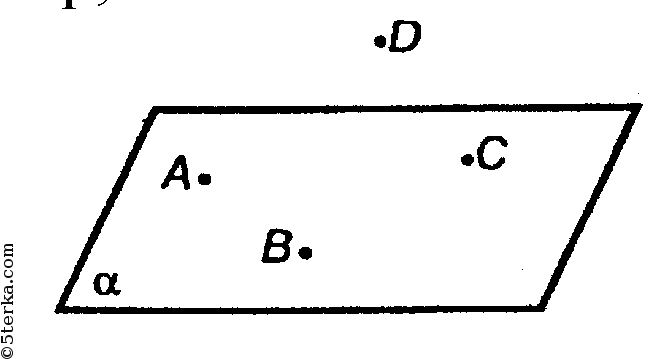

In [3]:
Image('images/плоскость2.png', width=500)

В этом случае давайте проводить плоскость такую, что расстояния от точек до этой плоскости будет минимальным.

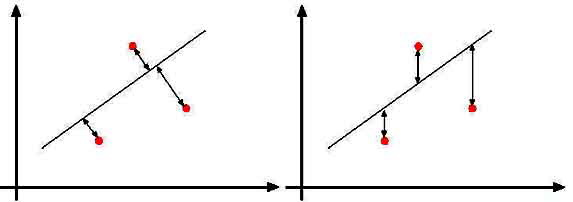

In [4]:
Image('images/расстояние.jpg')

Тут у нас есть вариант взять в качестве мерила близости знакомые нам $MSE$ (квадраты расстояний) или $MAE$ (модули расстояний)). Берем $MSE$, потому что ее можно легко дифференцировать.

А ещё это эквивалентно предположению о том, что шум в наших данных имеет нормальное распределение. А если *очень* что самом деле нужно предположить о данных, чтобы линейная регрессия могла строго решить задачу, то вот вам [теорема Гаусса-Маркова](https://ru.wikipedia.org/wiki/%D0%A2%D0%B5%D0%BE%D1%80%D0%B5%D0%BC%D0%B0_%D0%93%D0%B0%D1%83%D1%81%D1%81%D0%B0_%E2%80%94_%D0%9C%D0%B0%D1%80%D0%BA%D0%BE%D0%B2%D0%B0):)

Эту концепцию мы уже видели: мы вводим функционал ошибки
$$Q(a, X, \boldsymbol{y}) =  MSE = \frac{1}{n}\sum_{k=1}^{n} (a(\boldsymbol{x}_k)-y_k)^2 \rightarrow min$$

Который можно записать в более аккуратном матричном виде:
$$L(\boldsymbol{w}) = \frac{1}{n}\lVert X\boldsymbol{w} - \boldsymbol{y}\rVert^2 = \rightarrow min$$

$\lVert \boldsymbol{d} \rVert_2^2 = \sum_{i=1}^{n}d_1^2 + \ldots + d_n^2$ -квадрат нормы эвклидовой метрики (т.е. просто корень не извлекаем. На то, с какими весами достигается минимум это не влияет)

Теперь чтобы найти $w$ - применим уже известное с курса матана действие. Видим минимизацию дифференцируемой функции - смотрим на производную по вектору-аргументу или (для нас это то же самое) возьмем частные производные каждого $w_i$.

$$\nabla_{\boldsymbol{w}}L = \begin{cases}
\frac{\partial L}{\partial w_0} = \frac{1}{n}\sum_{k=1}^{n} 2x_{k, 0}(a(\boldsymbol{x}_k)-y_k)\\
\ldots \\
\frac{\partial L}{\partial w_i} = \frac{1}{n}\sum_{k=1}^{n} 2x_{k, i}(a(\boldsymbol{x}_k)-y_k)\\
\ldots \\
\frac{\partial L}{\partial w_m} = \frac{1}{n}\sum_{k=1}^{n} 2x_{k, m}(a(\boldsymbol{x}_k)-y_k)
\end{cases}$$

$\nabla_{\boldsymbol{w}}L$ - называется **градиентом** линейной функции $L$, по вектору параметров $\boldsymbol{w}$ 

Если на эту систему внимательно посмотреть (или изучить матричное дифференцирование), можно понять, что результат, полученный выше, можно записать тоже в матричном виде:

$$ \nabla_{\boldsymbol{w}}L = \frac{2}{n}X^{T}(X\boldsymbol{w} - \boldsymbol{y})$$

#### Математическая сноска
1. $L$ - это полином 2 степени относительно переменных $w$. Значит, 1-я и 2-я производная существует во всех точках.
2. $L$ - строго выпуклая функция, потому что ее Гессиан положительно определен. [Доказательство](https://math.stackexchange.com/a/3669812)
3. Если $L$ - строго выпуклая функция, значит она имеет не более одного минимума. [Доказательство](https://math.stackexchange.com/a/337393). А на ограниченном замкнутом множестве - строго один.

Осталось совершить последнее стандартное действие - приравнять производную к нулевому вектору и решить матричное уравнение.

$$ 0 = \frac{2}{n}X^{T}(X\boldsymbol{w} - \boldsymbol{y})$$

$$ X^{T}X\boldsymbol{w} = X^{T}\boldsymbol{y}$$

$$ \boldsymbol{w} = (X^{T}X)^{-1}X^{T}\boldsymbol{y}$$

Теперь давайте подумаем, избавилось ли данное решение от предыдущих проблем:
1. Матрица $X^{T}X$ - действительно квадратная размера $m\times m$
2. $rank(X) = rank(X^{T}X)$ ([доказательство](https://math.stackexchange.com/questions/2807892/prove-that-textrankxtx-textrankx))
3. $X^{T}X$ - положительно определенная, так как матрица X невырожденная и вещественнозначная

Следовательно - обратная матрица $(X^{T}X)^{-1}$ - существует. А значит получили новое решение, для функционала $MSE$.

## А что если объектов мало?

В редком случае у нас может случиться так, что $m > n$ (признаков больше чем объектов). Значит у системы $X\boldsymbol{w} = \boldsymbol{y}$ имеется бесконечно много решений.

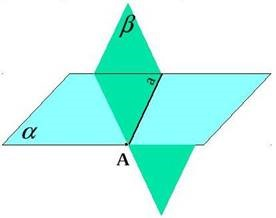

In [5]:
Image('images/плоскости.jpg')

Если же будем применять $MSE$, то получим, что матрица $X$ имеет ранг $n$, а значит матрица $X^{T}X$ - также имеет ранг $n$ (а не $m$, потому что $m > n$). В этом случае у нас опять не будет существовать решения.

В этом случае воcпользуемся еще одной эвристикой --- давайте найдем среди всех возможных вариантов для вектора $\boldsymbol{w}$ вектор с наименьшей нормой.
$$\lVert \boldsymbol{w} \rVert_2^2 \rightarrow \min$$

**Добавление доп. условия, превращающего задачу с множеством ответов в задачу с единственным ответом мы будет называть регуляризацией.**

Возьмем решение такого вида:
$$\boldsymbol{w} = X^{T}(XX^{T})^{-1}\boldsymbol{y}$$

- Почему это вообще решение? Можем проверить:

$$X\boldsymbol{w} = XX^{T}(XX^{T})^{-1}\boldsymbol{y} = \boldsymbol{y}$$

- Окей, а почему $(XX^{T})^{-1}$ - существует?

Потому что ранг $XX^{T}$ - матрица размера $n \times n$. В случае, когда $n < m$ у этой матрицы будет ранг $n$ - а значит существует обратная. (Получили интересное: в зависимости от того, какой ранг у $X$ у нас существует либо $(XX^{T})^{-1}$ либо $(X^{T}X)^{-1}$)

Осталось доказать, что это решение с минимальной нормой. Обозначим $\boldsymbol{w}^{*} = X^{T}(XX^{T})^{-1}\boldsymbol{y}$

Возьмем, 
какое-нибудь другое решение системы: $\boldsymbol{\hat{w}}$ (раз система недоопределенная, то их бесконечно много) 
и рассмотрим квадрат его нормы:

$||\boldsymbol{x}|| = \sqrt{\boldsymbol{\hat{x}}^{T}\boldsymbol{\hat{x}}}$ - Евклидова норма

$||\boldsymbol{\hat{w}}|| = ||\boldsymbol{\hat{w}} + \boldsymbol{w^{*}} - \boldsymbol{w^{*}}|| = ||\boldsymbol{w^{*}} + (\boldsymbol{\hat{w}}- \boldsymbol{w^{*}})||$

$||\boldsymbol{\hat{w}}||^2 = ||\boldsymbol{w^{*}} + (\boldsymbol{\hat{w}}- \boldsymbol{w^{*}})||^2 = (\boldsymbol{w^{*}} + (\boldsymbol{\hat{w}}- \boldsymbol{w^{*}}))^T (\boldsymbol{w^{*}} + (\boldsymbol{\hat{w}}- \boldsymbol{w^{*}})) = $

$ = (\boldsymbol{w^{*T}} + (\boldsymbol{\hat{w}}- \boldsymbol{w^{*}})^T) (\boldsymbol{w^{*}} + (\boldsymbol{\hat{w}}- \boldsymbol{w^{*}})) = \boldsymbol{w^{*T}}\boldsymbol{w^{*}} + (\boldsymbol{\hat{w}}- \boldsymbol{w^{*}})^T(\boldsymbol{\hat{w}}- \boldsymbol{w^{*}}) + \boldsymbol{w^{*T}}(\boldsymbol{\hat{w}}- \boldsymbol{w^{*}}) + (\boldsymbol{\hat{w}}- \boldsymbol{w^{*}})^T\boldsymbol{w^{*}} = $

$= ||\boldsymbol{w^{*}}||^2 + ||(\boldsymbol{\hat{w}}- \boldsymbol{w^{*}}))||^2+ \boldsymbol{w^{*T}}(\boldsymbol{\hat{w}}- \boldsymbol{w^{*}}) + (\boldsymbol{\hat{w}}- \boldsymbol{w^{*}})^T\boldsymbol{w^{*}}$

Так как $\boldsymbol{\hat{w}}$ и $\boldsymbol{w}^{*}$ - оба решения, то $X\boldsymbol{\hat{w}} = y = X\boldsymbol{w}^{*}$

$\boldsymbol{w^{*T}}(\boldsymbol{\hat{w}}- \boldsymbol{w^{*}}) = ( X^{T}(XX^{T})^{-1}\boldsymbol{y})^T(\boldsymbol{\hat{w}}- \boldsymbol{w^{*}}) = ((XX^{T})^{-1}\boldsymbol{y})^TX(\boldsymbol{\hat{w}}- \boldsymbol{w^{*}}) = ((XX^{T})^{-1}\boldsymbol{y})^T(X\boldsymbol{\hat{w}}- X\boldsymbol{w^{*}}) = ((XX^{T})^{-1}\boldsymbol{y})^T*0$

$X(\boldsymbol{\hat{w}}- \boldsymbol{w^{*}}) = 0 \rightarrow (\boldsymbol{\hat{w}}- \boldsymbol{w^{*}})^TX^T = 0^T = 0$

Получаем

$||\boldsymbol{\hat{w}}||^2 = ||\boldsymbol{w}^{*}||^2 + ||\boldsymbol{\hat{w}} - \boldsymbol{w}^{*}||^2 \rightarrow ||\boldsymbol{\hat{w}}||^2 \geq ||\boldsymbol{w}^{*}||^2 \rightarrow ||\boldsymbol{\hat{w}}|| \geq ||\boldsymbol{w}^{*}||$

Что означает, что норма нового решения либо больше, либо равна норме нашего $\boldsymbol{w^{*}}$. 
Значит $\boldsymbol{w}^{*}$ - минимальное по норме решение. 


Фух

На самом деле минимизация $MSE$ и минимизация нормы $\lVert \boldsymbol{w} \rVert_2^2$ - это крайности одной и той же задачи:

$$L =\frac{1}{n}(\frac{1}{2}\lVert X\boldsymbol{w} - \boldsymbol{y} \rVert_2^2 + \frac{\lambda}{2}\lVert \boldsymbol{w} \rVert_2^2) \rightarrow \min$$

То есть мы можем учитывать оба условия для нахождения наилучшего решения, варьируя между ними с помощью параметра $\lambda$.

Точным решением этой задачи минимизации будет
$$\boldsymbol{w} = (X^TX + \lambda E)^{-1}X^{T}\boldsymbol{y}$$

(можете вывести это самостоятельно или посмотреть схему вывода [тут](https://alexanderdyakonov.wordpress.com/2019/10/31/%D0%BB%D0%B8%D0%BD%D0%B5%D0%B9%D0%BD%D0%B0%D1%8F-%D1%80%D0%B5%D0%B3%D1%80%D0%B5%D1%81%D1%81%D0%B8%D1%8F/))

### Регуляризация может предотвратить переобучение!

Но почему?

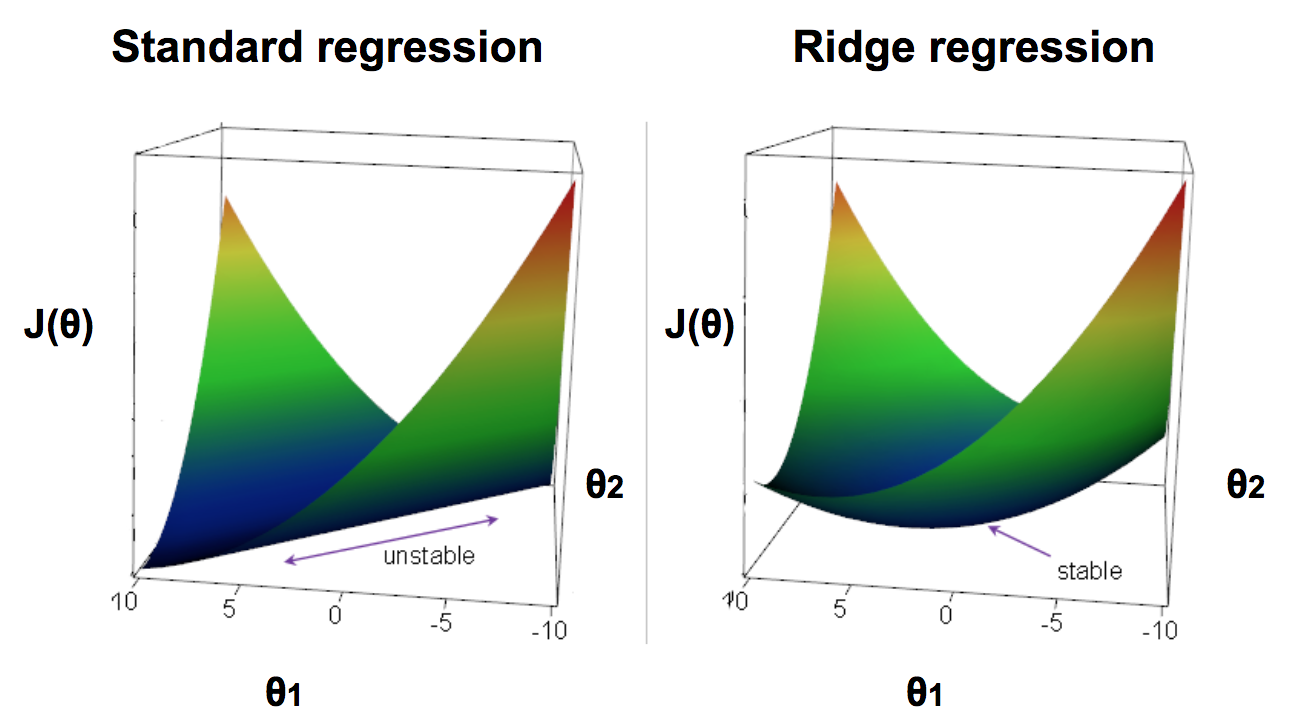

In [6]:
Image('images/ridge.png', width=500)

### Другие регуляризации

Еще на деле часто применяют $Lasso$ или $L1$ регуляризацию:
$$L =\frac{1}{n}(\frac{1}{2}\lVert X\boldsymbol{w} - \boldsymbol{y} \rVert_2^2 + \lambda\lVert \boldsymbol{w} \rVert) \rightarrow \min$$
$\lVert \boldsymbol{w} \rVert = \sum_{i=1}^{n}|w_i|$ - сумма модулей

О том как она выводится можете почитать [сами](https://stats.stackexchange.com/questions/17781/derivation-of-closed-form-lasso-solution).

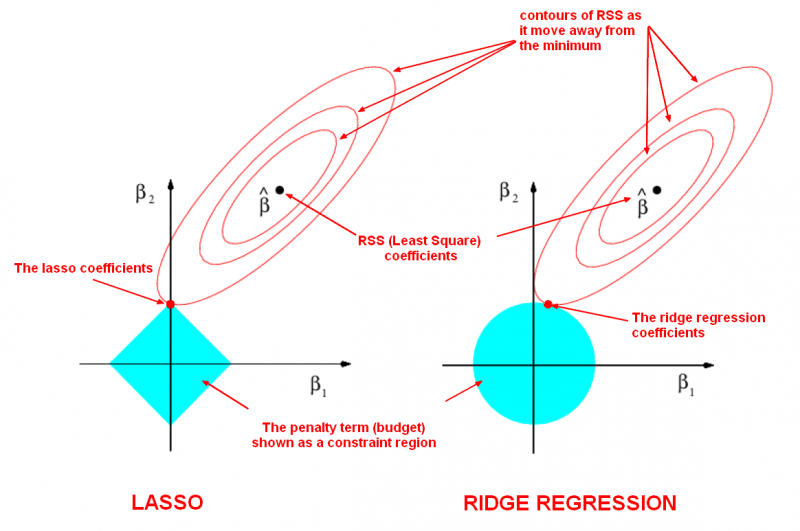

In [7]:
Image('images/lasso_ridge_coefficients.png', width=1000)

-------------

# Реальный мир

Мы долго говорили о красивой математике, чтобы сейчас ее разом выбросить. Посмотрим на наше решение

$$\boldsymbol{w} = (X^TX + \lambda E)^{-1}X^{T}\boldsymbol{y}$$

Подсчет обратной матрицы составляет [$O(m^3)$](https://ru.wikipedia.org/wiki/%D0%9E%D0%B1%D1%80%D0%B0%D1%82%D0%BD%D0%B0%D1%8F_%D0%BC%D0%B0%D1%82%D1%80%D0%B8%D1%86%D0%B0)

Перемножение 2-х матриц (n,k) и (k,m): [$O(nmk)$](https://ru.wikipedia.org/wiki/%D0%A3%D0%BC%D0%BD%D0%BE%D0%B6%D0%B5%D0%BD%D0%B8%D0%B5_%D0%BC%D0%B0%D1%82%D1%80%D0%B8%D1%86)

Суммарно у нас затратится $O(n^2m + m + m^3 + nm + m) = O(n^2m + m^3 )$


При $n > 100000$ мы уже вымрем, а это не такое уж  и большое число объектов для реальных задач мл. Нужно придумать что-то получше.

# 3.4 Градиентный спуск

Давайте вернемся к **градиенту**, который мы считали для регуляризации.

$$ \nabla_{\boldsymbol{w}}L = \frac{1}{n} X^{T}(X\boldsymbol{w} - \boldsymbol{y})$$

Градиент обозначает движение функции на возрастание. Почему бы нам не двигаться против возрастания функции, чтобы достичь минимума?

Пусть мы взяли какую-то точку на нашей гиперплоскости (инициализировали случайные веса) и посчитали градиент в этой точке и решили двигаться в другом направлении.

Для вектора
$$\boldsymbol{w}^{(t+1)} = \boldsymbol{w}^{(t)} - \eta \nabla_{\boldsymbol{w}}L $$

Для элемента вектора
$$w_i^{(t+1)} = w_i^{(t)} - \frac{\eta}{n} \sum_{k=1}^{n} 2x_{k, i}(a(\boldsymbol{x}_k)-y_k) $$


$t$ - номер итерации. 

$\eta$ - learning rate (коэффициент шага обучения)

Такой процесс назовем **градиентным спуском**. Очевидно, что градиентный спуск сходится в какой-нибудь минимум.

Остановиться можно, когда пройдет заданное нами количество итераций, или между соседними весами будет достаточно малый зазор:
$$\lVert \boldsymbol{w}^{(t+1)} - \boldsymbol{w}^{(t)}\rVert < epsilon$$

---

Для линейной регрессии с L2-нормой разности в качестве функционала ошибки, принимающей двумерные векторы на вход, расчёт градиента с использованием одного элемента из датасета выглядит примерно так:

Входные данные:
* $x = (x_1, x_2)$
* $y_0$ - верный ответ

$y(x) = x_0 + w_1 x_1 + w_2 x_2$

Тогда функционал ошибки запишется так:

$Q(x, y) = (y_0 - (x_0 + w_1 x_1 + w_2 x_2))^2 $

$\frac{f(g(x))}{dx} = f'(g(x))g'(x)$

$\frac{dy}{dw} = (\frac{dy}{dw_1}, \frac{dy}{dw_2}) =[-2(y_0 - (x_0 + w_1 x_1 + w_2 x_2))  x_1, -2(y_0 - (x_0 + w_1 x_1 + w_2 x_2)) x_2]$

### Упражнение

Возьмем параболу $f(x) = (x+4)^2$ и начнем градиентный спуск в точке $x = 10$. 
Давайте сойдемся в минимум.

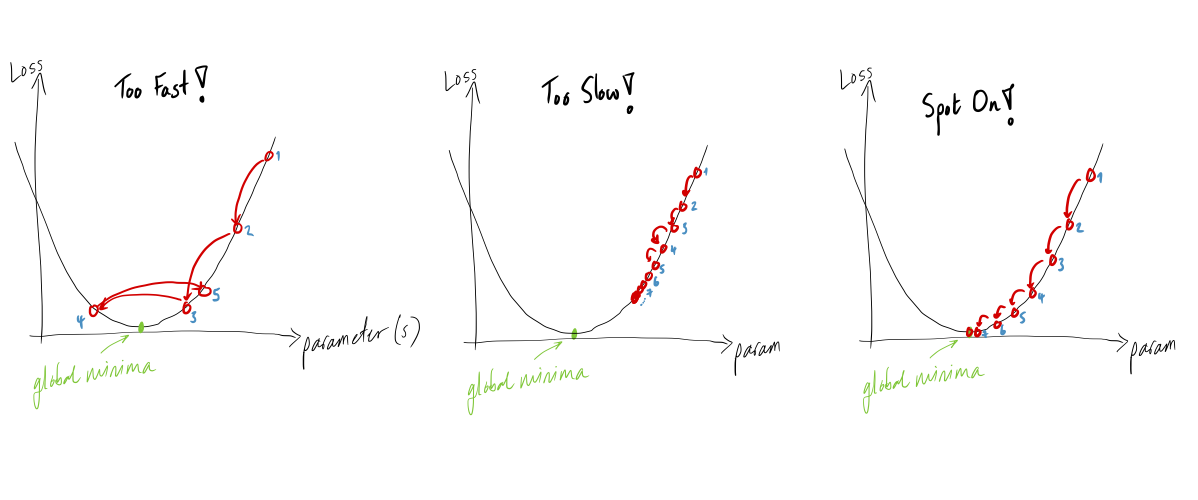

In [8]:
Image('images/step.png')

Для сложной многомерной функции выглядит как-то так

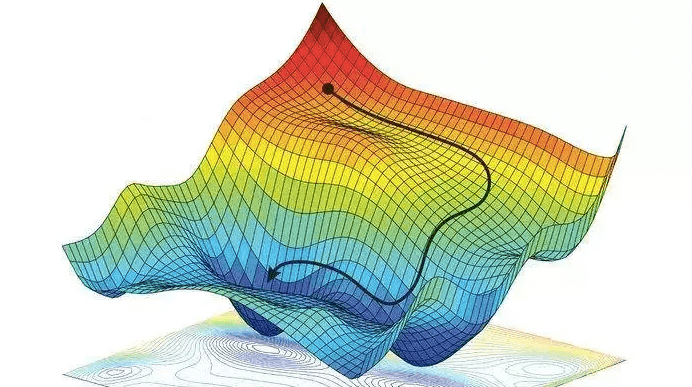

In [9]:
Image('images/grad.png', width=500)

Однако можем сойтись не в глобальный минимум, а в локальный.

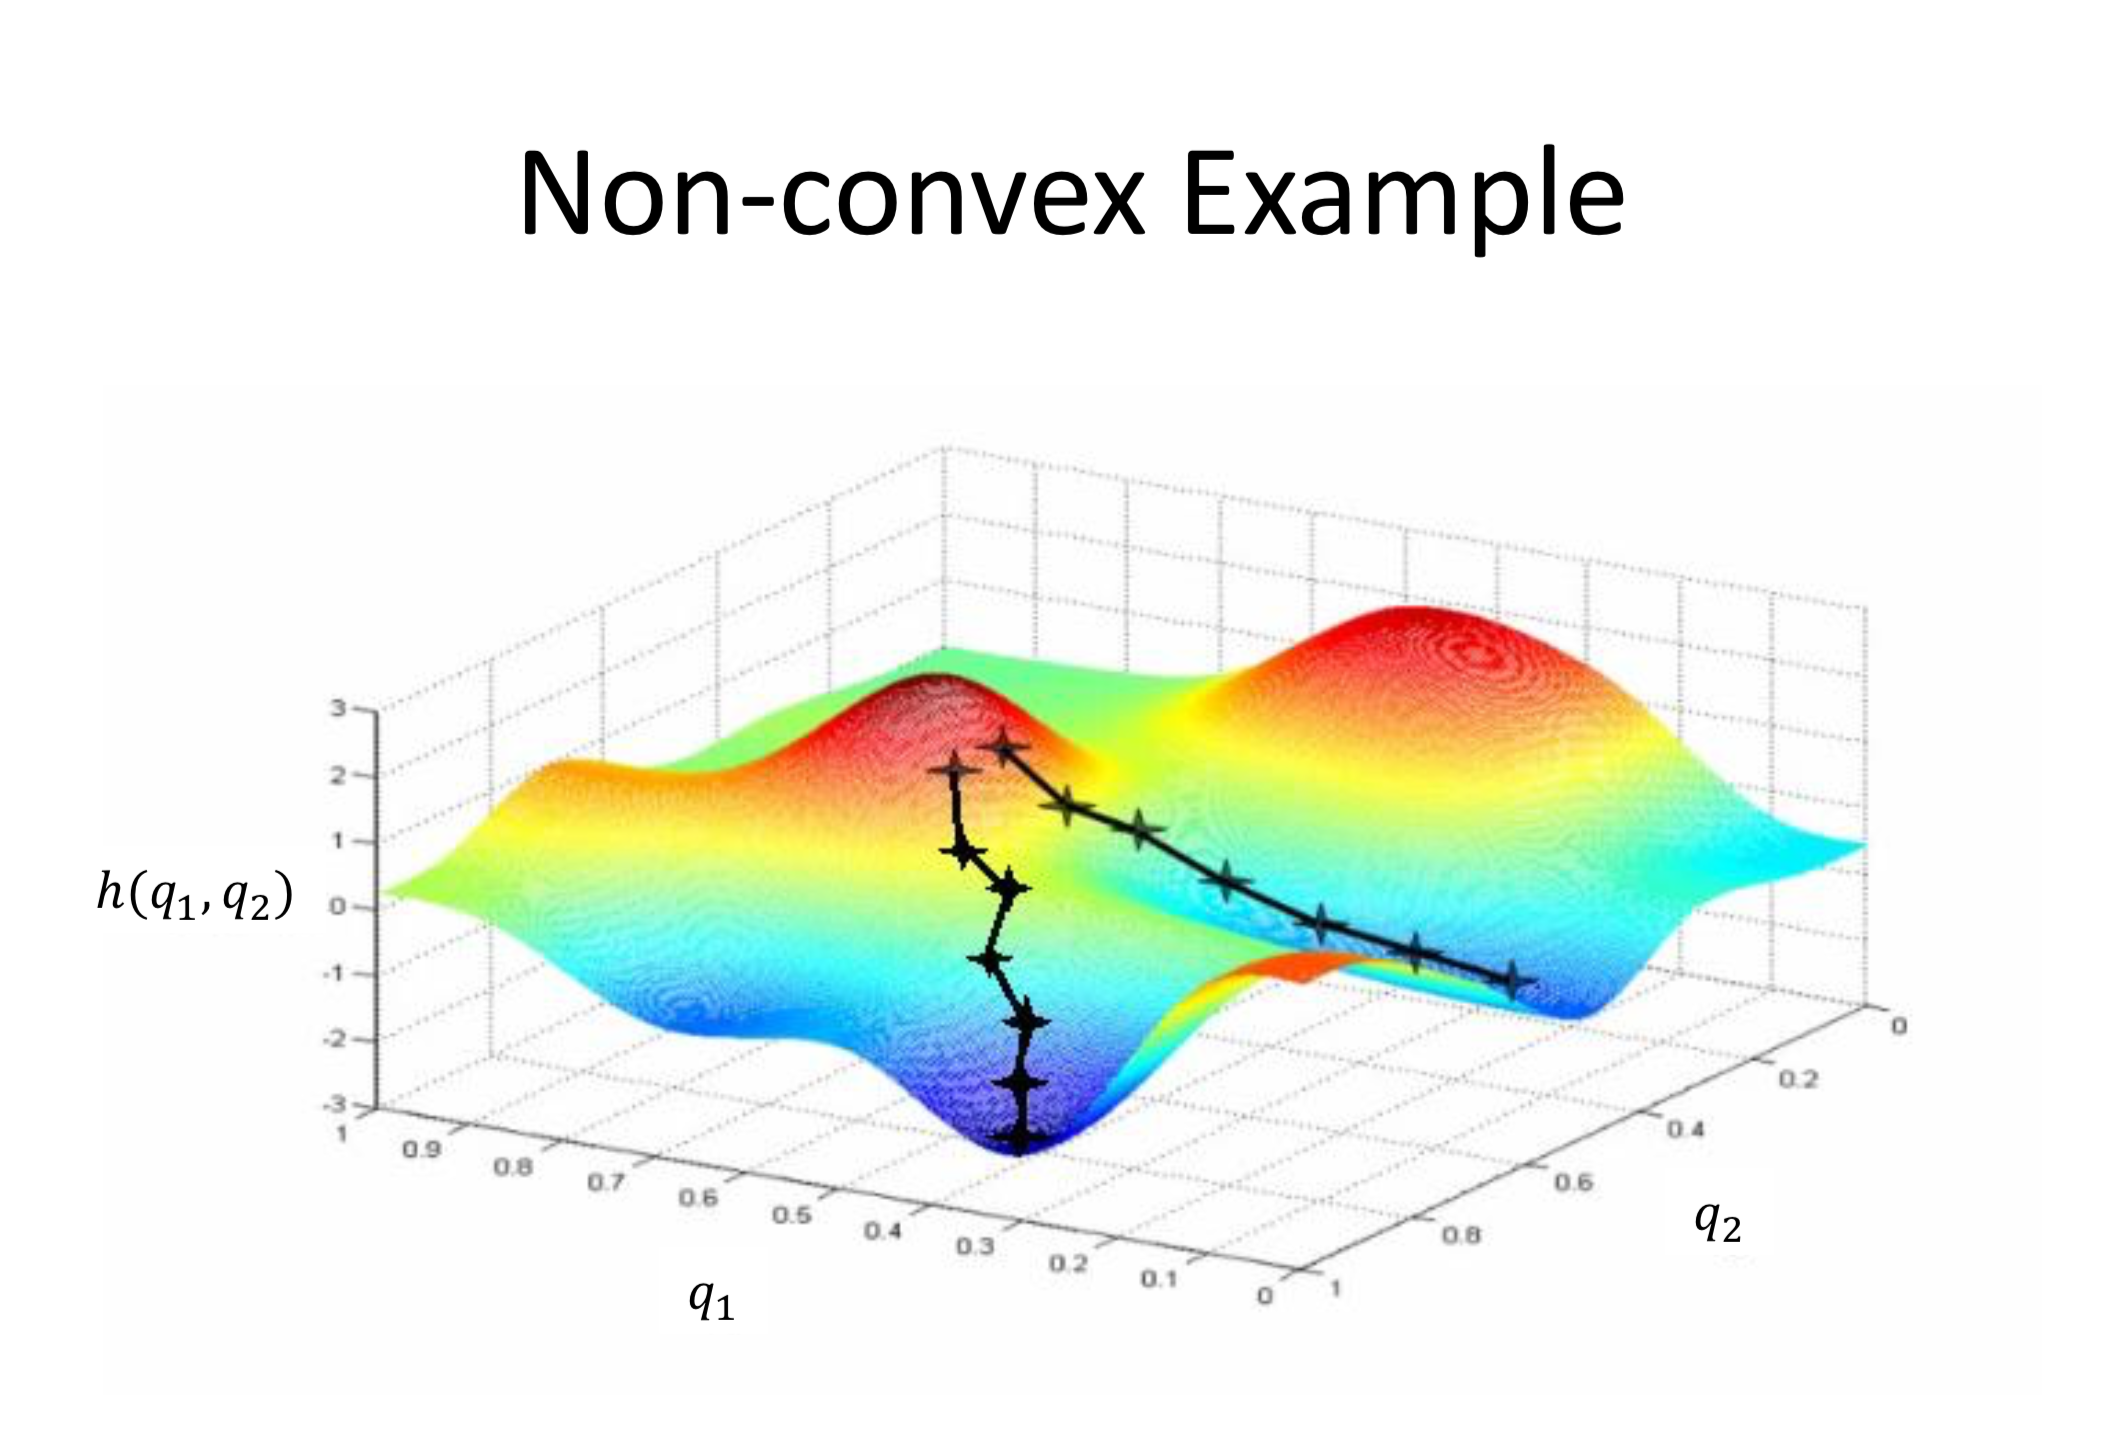

In [10]:
Image('images/local.png', width=500)

Очень важно выбрать правильный шаг, чтобы достигнуть минимума и не выйти случайно из него. Есть много математических эвристик для выбора шага, но на практике часто его приходится лавировать для определенной задачи.

Однако сложность алгоритма теперь $O(Tn^2)$, где $T$ - количество итераций. Не сильно лучше, чем было в честной регрессии. Но теперь мы можем улучшать конкретно градиентный спуск для ускорения сходимости.

# 3.5 Оптимизации градиентного спуска

## Стохастический градиентный спуск

А давайте теперь не к минимуму всей выборки, а только к **одному произвольному объекту**

Теперь вместо этого
$$ \nabla_{\boldsymbol{w}}L = \frac{2}{n}X^{T}(X\boldsymbol{w} - \boldsymbol{y})$$

Мы получили вот такое для произвольной пары $(\boldsymbol{x}_k, y_k)$

$$ \nabla_{\boldsymbol{w}}L^k = 2(\boldsymbol{x}_k)^{T}(\boldsymbol{x}_k^T\boldsymbol{w} - y_k)$$

**Это не k-ый элемент вектора градиента, это вектор градиента посчитанный только по объекту $\boldsymbol{x}_k$**

Тогда пересчет весов будет происходить соответственно

Для вектора
$$\boldsymbol{w}^{(t+1)} = \boldsymbol{w}^{(t)} - \eta \nabla_{\boldsymbol{w}}L^k$$

Для элемента вектора
$$w_i^{(t+1)} = w_i^{(t)} - \eta 2 x_{k,i}(a(\boldsymbol{x}_k)-y_k) $$

На двойку в целом наплевать

$$w_i^{(t+1)} = w_i^{(t)} - \eta x_{k,i}(a(\boldsymbol{x}_k)-y_k) $$


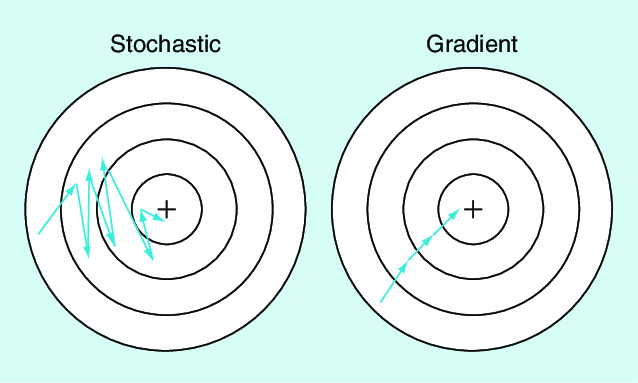

In [11]:
Image('images/sgd.png')

### Возможно мы сильно увеличили число итераций, однако теперь асимптотика алгоритма $O(Tn)$!!!

# 3.6 Логистическая регрессия

Как от задачи регрессии перейти к задаче бинарной классификации? Пусть теперь нам опять нужно построить прямую вида: 
$$a(\boldsymbol{x}_k) = \boldsymbol{x}_k^T\boldsymbol{w}$$

Только теперь необходимо, чтобы она была не как можно ближе к точкам, а как можно лучше разделяла их.

Множество точек $\boldsymbol{x}_k^T\boldsymbol{w} = 0$ является гиперплоскостью и делит пространство на 2 части по разные стороны от этой самой гиперплоскости. При этом объекты, расположенные по разные стороны от неё, полученный классификатор относит к различным классам в зависимости от знака скалярного произведения.

![](https://habrastorage.org/getpro/habr/post_images/555/369/344/5553693449d97a6ccb730f4760a2eacd.png)


Так давайте сделаем функцию 

$$a(\boldsymbol{x}) = sign(\boldsymbol{x}^T\boldsymbol{w})$$

$sign(z)$ - равна 0, если $z < 0$, $1$ если $z > 0$,. 

Вот только эта функция дискретная, а значит недиффиренцируема. Давайте найдем такую функцию, которая **однозначно** переводит $[-\infty, +\infty]$ в $[0, 1]$, то есть получим вероятности принадлежности к классу 1.

В качестве такой функции будем использовать [сигмоиду](https://ru.wikipedia.org/wiki/%D0%A1%D0%B8%D0%B3%D0%BC%D0%BE%D0%B8%D0%B4%D0%B0) (иногда называется логистическая функция): $$\sigma(z)=\frac{1}{1+e^{-z}}$$

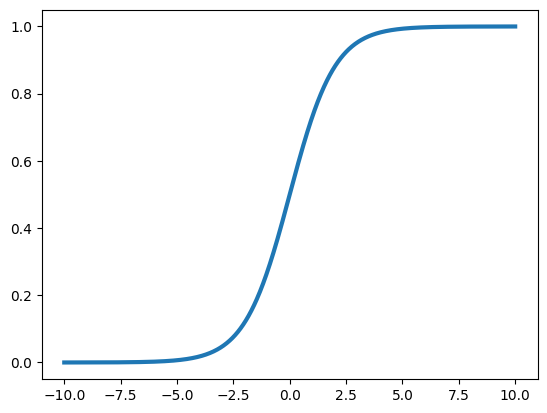

In [12]:
def sigmoid(x):
    return 1/(1 + np.e**(-x))

xs = np.linspace(-10,10,1001)
ys = np.vectorize(sigmoid)(xs)
_ = plt.plot(xs, ys, lw=3)

А новый алгоритм пусть теперь выглядит следующим образом:
$$a(x) = \begin{cases}
1, & \sigma(\boldsymbol{x}^T\boldsymbol{w}) > 0.5 \\ 
0, & \sigma(\boldsymbol{x}^T\boldsymbol{w}) < 0.5 \\ 
\end{cases}$$

Получили вероятность для $k$- го объекта:
$$P(y^{pred}_k=1|\boldsymbol{x}_k) = \sigma(\boldsymbol{x}_k^T\boldsymbol{w})$$

Это мы нашли вероятность того, что значение, которое мы предскажем, будет находиться в классе 1. Давайте теперь немного обобщим эту функцию. 
* $pred$ - предсказанное значение
* $real$ - реальное значение из выборки

$$P(y^{pred}_{k}=y^{real}_k|\boldsymbol{x}_k) = \sigma(\boldsymbol{x}_k^T\boldsymbol{w})^{y^{real}_k}(1 - \sigma(\boldsymbol{x}_k^T\boldsymbol{w}))^{1 - y^{real}_k}$$ 

Данная функция корректна, так как $y \in \{0, 1\}$

Окей, а какой функционал будем минимизировать?

А давайте найдем функцию правдоподобия:

$$Likelihood = \prod_{k=1}^{n}P(y^{pred}_k=y^{real}_k|\boldsymbol{x}_k) \rightarrow \max$$

Попытаемся сделать её более понятной - логарифмируем

$$\ln{Likelihood} =\sum_{k=1}^{n}\ln P(y^{pred}_{k}=y^{real}_k|\boldsymbol{x}_{k}) = $$
$$ = \sum_{k=1}^{n} y^{real}_k\ln\sigma(\boldsymbol{x}_k^T\boldsymbol{w}) + (1 - y^{real}_k)\ln(1 - \sigma(\boldsymbol{x}_k^T\boldsymbol{w})) =$$
$$= \sum_{k=1}^{n} y^{real}_k\ln p + (1 - y^{real}_k)\ln(1 - p)$$ 

Этот функционал называется $Logloss$. Так как функцию правдоподобия нужно максимизировать, чтобы получить наилучший результат. Мы будем минимизировать отрицательное правдоподобие, чтобы получить функционал минимизации.

$$Q(w) = -lnL \rightarrow \min$$

И вот уже эту функцию можно использовать для градиентного спуска, с помощью которого будем искать наилучшие веса:
$$\boldsymbol{w}^{t+1} = \boldsymbol{w}^{t} - \eta \nabla_{\boldsymbol{w}}\ln{L}$$


Подробнее про вывод и свойства LogLoss можно почитать [тут](https://alexanderdyakonov.wordpress.com/2018/03/12/%d0%bb%d0%be%d0%b3%d0%b8%d1%81%d1%82%d0%b8%d1%87%d0%b5%d1%81%d0%ba%d0%b0%d1%8f-%d1%84%d1%83%d0%bd%d0%ba%d1%86%d0%b8%d1%8f-%d0%be%d1%88%d0%b8%d0%b1%d0%ba%d0%b8/)